# <p style="text-align: center;">FIT5196 Assignment 3</p>

### Student Name : Robert
### Student ID       : 28243447

Last Updated: 26 October 2018

Environment: Python 3.6.0 and Jupyter notebook Libraries used
* pandas (an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language)
* xml.etree.ElementTree (library to load the xml file)
* numpy (a powerful N-dimensional array object)
* math (provides access to the mathematical functions defined by the C standard)
* matplotlib (a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms)
* json_normalize (“Normalize” semi-structured JSON data into a flat table)
* json (a lightweight data interchange format inspired by JavaScript object literal syntax)
* MultiPoint, Point, Polygon (library to find the boundary of a polygon)
* shapefile (library to read shape file)
* sklearn (provide machine learning in Python)


The content of this assignment is:
    1. Introduction
    2. Import Libraries
    3. Data Integration
        3.1. Integrating Real Estate Data
            3.1.1. Combining Real Estate Data¶
            3.1.2. Removing Duplicate Rows
        3.2. Integrating Shopping Center Data
        3.3. Integrating Hospital Data
        3.4. Integrating Supermarket Data
        3.5. Integrating Suburb File
        3.6. Integrating GTFS files
            3.6.1. Finding the Closest Train Station
            3.6.2. Finding the Transfer Flag
            3.6.3. Finding the Second Closest Train Station
            3.6.4. Calculating the Travel Time to CBD
        3.7. Export The Result
    4. Data Reshaping
        4.1. Data Normalization/Transformation on the "Price"
        4.2. Building a Linear Model
            4.2.1. Data Normalization
            4.2.2. Data Transformation
            4.2.2.1. Data Tranformation on the "Bedrooms"
            4.2.2.2. Data Tranformation on the "Bathrooms"¶
            4.2.2.3. Data Tranformation on the "Parking Space"
    5. Conclusion



# 1. Introduction
This FIT5196 assessment integrates multiple different datasets from multiple formats into 1 single dataset. There are several input files for this assessment, namely:
* `real_state.json` : dataset about real estate data in Victoria in json format
* `real_state.xml`: dataset about real estate data in Victoria in xml format
* `shopingcenters.html`: dataset about shopping centers in Victoria in html format
* `hospitals.json`: dataset about hospitals in Victoria in json format
* `supermarkets.xlsx`: dataset about supermarkets in Victoria in xlsx format
* `VIC_LOCALITY_POLYGON_shp`: dataset about suburbs in Victoria in shape file
* `stops.txt`, `calendar.txt`, `stop_times.txt`, and `trips.txt`: GTFS dataset about transport in Victoria

Meanwhile, the output file is `28243447_solution.csv`
More details for each task will be given in the following sections.


# 2. Import Libraries

In [216]:
import pandas as pd
import xml.etree.ElementTree as etree
import numpy as np
from math import sin, cos, sqrt, atan2, radians, ceil
import matplotlib 
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json as json
from shapely.geometry import MultiPoint, Point, Polygon
import shapefile
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
pd.options.mode.chained_assignment = None

# 3. Data Integration
## 3.1. Integrating Real Estate Data
### 3.1.1. Combining Real Estate Data
In this section, we will combine the real estate data from json and xml format into one dataframe.

In [217]:
# load json file
with open('28243447/real_state.json') as json_data:
    data = json.load(json_data)
estate_json = json_normalize(data)
print(estate_json.shape)
estate_json.head()

(1010, 10)


,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,24 Goldsmith Street,1.0,3.0,-37.878869,144.984322,2.0,19110000.0,84797.0,house,2013.0
1,5 Clunies Ross Crescent,1.0,4.0,-37.915789,145.160091,2.0,7830000.0,78128.0,house,2012.0
2,1/39 Eulinga Road,1.0,3.0,-37.932252,145.101746,1.0,7200000.0,76493.0,house,2012.0
3,7 Patterson Road,2.0,3.0,-37.924610,145.027649,1.0,9452000.0,96158.0,house,2008.0
4,34 Fairy Street,2.0,2.0,-37.776399,145.039157,2.0,25500000.0,38847.0,house,2015.0


Now, we will check the null rows in the dataset.

In [218]:
# Remove the null rows
estate_json.dropna(how='all', inplace=True)
print(estate_json.shape)
estate_json.head()

(1005, 10)


,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,24 Goldsmith Street,1.0,3.0,-37.878869,144.984322,2.0,19110000.0,84797.0,house,2013.0
1,5 Clunies Ross Crescent,1.0,4.0,-37.915789,145.160091,2.0,7830000.0,78128.0,house,2012.0
2,1/39 Eulinga Road,1.0,3.0,-37.932252,145.101746,1.0,7200000.0,76493.0,house,2012.0
3,7 Patterson Road,2.0,3.0,-37.924610,145.027649,1.0,9452000.0,96158.0,house,2008.0
4,34 Fairy Street,2.0,2.0,-37.776399,145.039157,2.0,25500000.0,38847.0,house,2015.0


It can be seen that, the total number of rows from the original data is 1010 rows. After we removed the rows with null values, the remaining rows are 1005. Now, we will check if there is wrong value in property_id.

In [219]:
print(sorted(estate_json.property_id.unique())[:5])
print(sorted(estate_json.property_id.unique())[-5:])

[187.0, 228.0, 275.0, 345.0, 519.0]
[96078.0, 96158.0, 96500.0, 96554.0, 96587.0]


It can be seen that, there is no wrong value in the property_id. Now, we will load the xml file.

In [220]:
# load xml file
tree = etree.parse("28243447/real_state.xml") 
root = tree.getroot()
for i in range (len(root)):
    xml_dict = {}
    for child in root[i]:
        xml_dict[child.tag] = child.text
    temp = pd.DataFrame.from_dict(xml_dict,orient='index')
    temp.columns = [root[i].tag]
    if i == 0:
        estate_xml = temp
    else:
        estate_xml = estate_xml.join(temp, how='outer')

# drop and reset index
estate_xml.reset_index(drop=True, inplace=True)

print(estate_xml.shape)
estate_xml.head()

(1004, 10)


,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,2.0,4221000.0,4.0,1.0,2012.0,-37.980147,145.211263,house,1A High Street,80941.0
1,1.0,2340000.0,3.0,0.0,2008.0,-37.65868378,144.9272003,house,76 LONGFORD CRESCENT,19491.0
2,1.0,8456000.0,3.0,2.0,2013.0,-37.739517,145.020548,house,96 Murray Road,33320.0
3,2.0,4185000.0,4.0,2.0,2014.0,-37.807939,145.304562,house,16 COSMO COURT,65153.0
4,1.0,5894000.0,3.0,1.0,2009.0,-37.81635666,145.1490479,house,29 O'Hara Street,57940.0


In [221]:
# Drop the null rows
estate_xml.dropna(how='all', inplace=True)
print(estate_xml.shape)
estate_xml.head()

(1004, 10)


,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,2.0,4221000.0,4.0,1.0,2012.0,-37.980147,145.211263,house,1A High Street,80941.0
1,1.0,2340000.0,3.0,0.0,2008.0,-37.65868378,144.9272003,house,76 LONGFORD CRESCENT,19491.0
2,1.0,8456000.0,3.0,2.0,2013.0,-37.739517,145.020548,house,96 Murray Road,33320.0
3,2.0,4185000.0,4.0,2.0,2014.0,-37.807939,145.304562,house,16 COSMO COURT,65153.0
4,1.0,5894000.0,3.0,1.0,2009.0,-37.81635666,145.1490479,house,29 O'Hara Street,57940.0


It can be seen that there is no row with null value. Now we will check if there is wrong property_id.

In [222]:
print(sorted(estate_xml.property_id.unique())[:5])
print(sorted(estate_xml.property_id.unique())[-5:])

['10072.0', '10119.0', '10192.0', '10208.0', '10286.0']
['9866.0', '9906.0', '993.0', '997.0', 'nan']


It can be seen that there is a "nan" value in the property_id. We will investigate this problem.

In [223]:
# check nan rows
print(len(estate_xml[estate_xml.property_id=="nan"]))
estate_xml[estate_xml.property_id=="nan"].head()

11


,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
96,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
316,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
472,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


It can be seen that there is 11 rows with "nan" values in all columns. We will remove them because they will produce bias in the data.

In [224]:
# drop nan rows
estate_xml.drop(estate_xml[(estate_xml[estate_xml.columns.tolist()] == "nan").all(axis=1)].index, inplace=True)

In [225]:
estate_xml.shape

(993, 10)

It can be seen that after we remove them, the remaining rows are 993. Now, we will combine the json and xml files.

In [226]:
# combine json and xml files
estate = estate_xml.append(estate_json, ignore_index=True)
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,1A High Street,2.0,4.0,-37.980147,145.211263,1.0,4221000.0,80941.0,house,2012.0
1,76 LONGFORD CRESCENT,1.0,3.0,-37.65868378,144.9272003,0.0,2340000.0,19491.0,house,2008.0
2,96 Murray Road,1.0,3.0,-37.739517,145.020548,2.0,8456000.0,33320.0,house,2013.0
3,16 COSMO COURT,2.0,4.0,-37.807939,145.304562,2.0,4185000.0,65153.0,house,2014.0
4,29 O'Hara Street,1.0,3.0,-37.81635666,145.1490479,1.0,5894000.0,57940.0,house,2009.0


In [227]:
# check columns datatype
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 10 columns):
addr_street      1998 non-null object
bathrooms        1998 non-null object
bedrooms         1998 non-null object
lat              1998 non-null object
lng              1998 non-null object
parking_space    1998 non-null object
price            1998 non-null object
property_id      1998 non-null object
property_type    1998 non-null object
year             1998 non-null object
dtypes: object(10)
memory usage: 156.2+ KB


Now, we will check the datatype of the columns in `sample.csv`

In [228]:
sample = pd.read_csv('sample.csv')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 22 columns):
Unnamed: 0                   4 non-null int64
property_id                  4 non-null int64
lat                          4 non-null float64
lng                          4 non-null float64
addr_street                  4 non-null object
suburb                       4 non-null object
price                        4 non-null int64
property_type                4 non-null object
year                         4 non-null int64
bedrooms                     4 non-null int64
bathrooms                    4 non-null int64
parking_space                4 non-null int64
shopping_center_id           4 non-null object
distance_to_sc               4 non-null int64
train_station_id             4 non-null int64
distance_to_train_station    4 non-null int64
travel_min_to_CBD            4 non-null int64
transfer_flag                4 non-null int64
hospital_id                  4 non-null object
distance_to_hosp

It can be seen that the data types of some columns from estate dataframe is different with the datatypes of columns from sample dataframe. Therefore, we will convert the datatypes based on `sample.csv`

In [229]:
# convert columns datatype based on sample.csv

# bathrooms
estate.bathrooms = estate.bathrooms.astype(float)
estate.bathrooms = estate.bathrooms.astype(int)

# bedrooms
estate.bedrooms = estate.bedrooms.astype(float)
estate.bedrooms = estate.bedrooms.astype(int)

estate.lat = estate.lat.astype(float)
estate.lng = estate.lng.astype(float)

# parking space
estate.parking_space = estate.parking_space.astype(float)
estate.parking_space = estate.parking_space.astype(int)

# price
estate.price = estate.price.astype(float)
estate.price = estate.price.astype(int)

# property id
estate.property_id = estate.property_id.astype(float)
estate.property_id = estate.property_id.astype(int)

# year
estate.year = estate.year.astype(float)
estate.year = estate.year.astype(int)

estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 10 columns):
addr_street      1998 non-null object
bathrooms        1998 non-null int64
bedrooms         1998 non-null int64
lat              1998 non-null float64
lng              1998 non-null float64
parking_space    1998 non-null int64
price            1998 non-null int64
property_id      1998 non-null int64
property_type    1998 non-null object
year             1998 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 156.2+ KB


### 3.1.2. Removing Duplicate Rows
In this section, we will check the duplicate rows.

In [230]:
# check duplicate rows
print(estate[estate.duplicated()].sort_values(by=['property_id']).shape)
estate[estate.duplicated()].sort_values(by=['property_id']).head()

(33, 10)


,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
1012,11 Akuna Street,1,4,-37.863778,144.817067,3,5940000,4833,house,2014
1197,46 Furlong Rd,2,4,-37.757736,144.784576,3,8415000,8530,house,2009
1674,5 Tyabb Court,1,3,-37.680588,144.905930,1,2453000,18977,house,2008
998,8 Little Jones Street,2,2,-37.761690,144.964545,1,6000000,21564,house,2010
1000,20 Ebony Circuit,2,3,-37.581264,144.906815,1,6341000,25896,house,2010


It can be seen that there are 33 duplicate rows. We will remove them because they will produce bias of the data.

In [231]:
# drop duplicate rows
estate.drop_duplicates(inplace=True)

In [232]:
estate[estate.duplicated()].sort_values(by=['property_id']).head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year


In [233]:
len(estate)

1965

There is no more duplicate row. It means we fixed this problem.

In [234]:
display(estate.describe())
display(estate.describe(include='O'))

,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,year
count,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1.965000e+03,1965.000000,1965.000000
mean,1.568957,3.240712,-37.808416,145.042323,1.535369,9.266826e+06,48579.376590,2012.230534
std,0.625293,0.765586,0.097652,0.133836,0.788406,6.002745e+06,27931.385052,2.577769
min,1.000000,1.000000,-38.078447,144.637281,0.000000,1.280000e+06,187.000000,2005.000000
25%,1.000000,3.000000,-37.867985,144.955423,1.000000,5.265000e+06,24401.000000,2010.000000
50%,1.000000,3.000000,-37.806133,145.036622,2.000000,7.548000e+06,49104.000000,2012.000000
75%,2.000000,4.000000,-37.738352,145.123198,2.000000,1.116000e+07,73298.000000,2014.000000
max,3.000000,5.000000,-37.572108,145.368996,3.000000,4.284000e+07,96587.000000,2016.000000


,addr_street,property_type
count,1965,1965
unique,1962,1
top,11 Kent Street,house
freq,2,1965


## 3.2. Integrating Shopping Center Data
In this section, we will integrate the closest shopping center id and distance to the real estate dataset.

In [235]:
# Function to find the distance
def calculate_radian (lat1, lon1, lat2, lon2):
    R = 6378
    dlon = radians(lon2) - radians(lon1)
    dlat = radians(lat2) - radians(lat1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000

# Function to find the closest id
def find_closest_id(lat, long, facility):
    dict2 = {}
    for key, value in facility.items():
        result = calculate_radian(value[0],value[1], lat, long)
        dict2[key] = result
    return min(dict2, key=lambda key: dict2[key])

# Function to dint the distance to the closest id
def find_closest_dist(lat, long, facility):
    dict2 = {}
    for key, value in facility.items():
        result = calculate_radian(value[0],value[1], lat, long)
        dict2[key] = result
    return dict2[min(dict2, key=lambda key: dict2[key])]


In [236]:
# Load shopping center file
shopping = pd.read_html('28243447/shopingcenters.html')
shopping = shopping[0]
shopping.head()

,Unnamed: 0,sc_id,lat,lng
0,0,SC_001,-37.767915,145.041790
1,1,SC_002,-37.819375,145.171472
2,2,SC_003,-37.971131,145.089065
3,3,SC_004,-35.280406,149.132550
4,4,SC_005,-37.574572,144.920451


In [237]:
# dictionary for shopping centers data
process_dict = shopping[['sc_id','lat','lng']].set_index('sc_id').T.to_dict('list')

# Find the closest shopping center
estate['shopping_center_id']= np.vectorize(find_closest_id)(estate['lat'],estate['lng'], facility=process_dict)

# Calculate the distance to the closest shopping center
estate['distance_to_sc']= np.vectorize(find_closest_dist)(estate['lat'],estate['lng'], facility=process_dict)

In [238]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767


It can be seen that we have integrated the closest shopping center id and distance to the real estate dataset.

## 3.3. Integrating Hospital Data
In this section, we will integrate the closest hospital id and distance to the real estate dataset.

In [239]:
# Load hospital file
with open('28243447/hospitals.json') as json_data:
    hosp = json.load(json_data)
hospital = json_normalize(hosp)
print(hospital.shape)
hospital.head()

(199, 4)


,id,lat,lng,name
0,hospital_001,-37.990622,145.072836,Como Private Hospital
1,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
2,hospital_003,-37.792230,144.889128,Western Hospital
3,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
4,hospital_005,-37.760623,144.815624,Sunshine Hospital


In [240]:
# dictionary for shopping centers data
process_dict = hospital[['id','lat','lng']].set_index('id').T.to_dict('list')

# Find the closest hospital
estate['hospital_id']= np.vectorize(find_closest_id)(estate['lat'],estate['lng'], facility=process_dict)

# Calculate the distance to the closest hospital
estate['distance_to_hospital']= np.vectorize(find_closest_dist)(estate['lat'],estate['lng'], facility=process_dict)

In [241]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564,hospital_033,600.297463
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559,hospital_104,1071.363865
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603,hospital_090,2443.253467
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897,hospital_164,4306.879994
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767,hospital_060,1948.921804


It can be seen that we have integrated the closest hospital id and distance to the real estate dataset.

## 3.4. Integrating Supermarket Data

In this section, we will integrate the closest supermarket id and distance to the real estate dataset.

In [242]:
# Load supermarket file
supermarket = pd.read_excel('28243447/supermarkets.xlsx')
supermarket.head()

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths


In [243]:
process_dict = supermarket[['id','lat','lng']].set_index('id').T.to_dict('list')

# Find the closest supermarket
estate['supermarket_id']= np.vectorize(find_closest_id)(estate['lat'],estate['lng'], facility=process_dict)

# Calculate the distance to the closest supermarket
estate['distance_to_supermaket']= np.vectorize(find_closest_dist)(estate['lat'],estate['lng'], facility=process_dict)

In [244]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564,hospital_033,600.297463,S_183,377.079315
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559,hospital_104,1071.363865,S_153,2214.911940
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603,hospital_090,2443.253467,S_084,1581.199213
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897,hospital_164,4306.879994,S_224,822.102909
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767,hospital_060,1948.921804,S_018,1683.535834


It can be seen that we have integrated the closest supermarket id and distance to the real estate dataset.

## 3.5. Integrating Suburb File

In this section, we will find the suburb of the real estate using the shape file.

In [245]:
# Read the shape file
sf = shapefile.Reader("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")
shapes = sf.shapes()
record = sf.records()
num_of_shape = sf.numRecords

# Function to find the suburb
def finding_suburb(lat,lng):
    point = Point(lng,lat)
    for i in range(num_of_shape):
        if Polygon(shapes[i].points).contains(point):
            suburb = record[i][6]
            return suburb.title()
    return None

In [246]:
# Find the suburb
estate['suburb']= np.vectorize(finding_suburb)(estate['lat'],estate['lng'])

In [247]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564,hospital_033,600.297463,S_183,377.079315,Dandenong
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559,hospital_104,1071.363865,S_153,2214.911940,Coolaroo
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603,hospital_090,2443.253467,S_084,1581.199213,Preston
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897,hospital_164,4306.879994,S_224,822.102909,Kilsyth
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767,hospital_060,1948.921804,S_018,1683.535834,Blackburn


It can be seen that we have integrated the suburb name to the real estate dataset.

## 3.6. Integrating GTFS files

### 3.6.1. Finding the Closest Train Station

In this section, we will find the closest station id and distance to the real estate dataset.

In [248]:
# Load the stops file
stops = pd.read_csv('GTFS - Melbourne Train Information/stops.txt', sep=",")
stops.head()

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


In [249]:
process_dict = stops[['stop_id','stop_lat','stop_lon']].set_index('stop_id').T.to_dict('list')

# Find the closest station
estate['train_station_id']= np.vectorize(find_closest_id)(estate['lat'],estate['lng'], facility=process_dict)

# Calculate the distance to the closest station
estate['distance_to_train_station']= np.vectorize(find_closest_dist)(estate['lat'],estate['lng'], facility=process_dict)

In [250]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564,hospital_033,600.297463,S_183,377.079315,Dandenong,19888,1101.528248
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559,hospital_104,1071.363865,S_153,2214.911940,Coolaroo,44817,277.129489
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603,hospital_090,2443.253467,S_084,1581.199213,Preston,20012,1765.389494
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897,hospital_164,4306.879994,S_224,822.102909,Kilsyth,19878,2525.784372
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767,hospital_060,1948.921804,S_018,1683.535834,Blackburn,19898,422.071378


It can be seen that we have integrated the train station id and distance to the real estate dataset.

### 3.6.2. Finding the Transfer Flag

In this section, we will find the transfer flag. Transfer flag is a Boolean attribute indicating whether there is a direct trip to the Flinders street station from the closest station between 7-9am on the weekdays. This flag is 0 if there is a direct trip and 1 otherwise.

In [251]:
# Load the calender file
calendar = pd.read_csv('GTFS - Melbourne Train Information/calendar.txt', sep=",")
calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018


In [252]:
# Load the stop_times file
stop_times = pd.read_csv('GTFS - Melbourne Train Information/stop_times.txt', sep=",")
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


In [253]:
# Load the trips file
trips = pd.read_csv('GTFS - Melbourne Train Information/trips.txt', sep=",")
trips.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


In [254]:
# Merge calendar and trips dataframes
gtfs = pd.merge(calendar, trips, how='outer', on=['service_id'])

# Merge gtfs and stop_times dataframes
gtfs = pd.merge(gtfs, stop_times, how='outer', on=['trip_id'])

# Merge gtfs and stops dataframes
gtfs = pd.merge(gtfs, stops, how='outer', on=['stop_id'])
gtfs.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,...,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name,stop_short_name,stop_lat,stop_lon
0,T2,0,0,0,0,0,1,0,20151009,20151011,...,19847,1,NaN,0,0,0.0,Alamein Railway Station,Ashburton,-37.86832,145.079656
1,T2,0,0,0,0,0,1,0,20151009,20151011,...,19847,1,NaN,0,0,0.0,Alamein Railway Station,Ashburton,-37.86832,145.079656
2,T2,0,0,0,0,0,1,0,20151009,20151011,...,19847,1,NaN,0,0,0.0,Alamein Railway Station,Ashburton,-37.86832,145.079656
3,T2,0,0,0,0,0,1,0,20151009,20151011,...,19847,1,NaN,0,0,0.0,Alamein Railway Station,Ashburton,-37.86832,145.079656
4,T2,0,0,0,0,0,1,0,20151009,20151011,...,19847,1,NaN,0,0,0.0,Alamein Railway Station,Ashburton,-37.86832,145.079656


Because we want to find the trips data during weekdays, therefore, we will filter the dataframe.

In [255]:
# Filter the dataframe to find weekdays trips
gtfs = gtfs[(gtfs.monday==1)&(gtfs.tuesday==1)&(gtfs.wednesday==1)&(gtfs.thursday==1)&(gtfs.friday==1)]

# Drop unnecessary columns.
gtfs.drop(['service_id','monday','tuesday','wednesday','thursday','friday','saturday','sunday','start_date','end_date'], axis=1, inplace=True)
gtfs.drop(['stop_sequence','stop_headsign','pickup_type','drop_off_type','shape_dist_traveled'], axis=1, inplace=True)
print(gtfs.shape)
gtfs.head()

(42900, 12)


,route_id,trip_id,shape_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
900,2-ALM-F-mjp-1,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0,05:01:00,05:01:00,19847,Alamein Railway Station,Ashburton,-37.86832,145.079656
901,2-ALM-F-mjp-1,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0,09:38:00,09:38:00,19847,Alamein Railway Station,Ashburton,-37.86832,145.079656
902,2-ALM-F-mjp-1,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0,09:53:00,09:53:00,19847,Alamein Railway Station,Ashburton,-37.86832,145.079656
903,2-ALM-F-mjp-1,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0,10:07:00,10:07:00,19847,Alamein Railway Station,Ashburton,-37.86832,145.079656
904,2-ALM-F-mjp-1,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0,10:23:00,10:23:00,19847,Alamein Railway Station,Ashburton,-37.86832,145.079656


Becasuse we only need the trips between 7am - 9pm, therefore, we will filter the dataframe based on that condition.

In [256]:
# Filter dataframe to find the trips between 7-9 am
gtfs = gtfs[((gtfs.stop_id==19854)&(gtfs.departure_time>='07:00:00')) | ((gtfs.departure_time>='07:00:00')&(gtfs.departure_time<='09:00:00'))]

In [257]:
# Sort the dataframe based on trip_id and departure_time
gtfs = gtfs.sort_values(by=['trip_id','departure_time'])

In [258]:
# Remove the trip_id with only 1 row, because it only contains Flinder Station
bytag = gtfs.groupby('trip_id').aggregate(np.count_nonzero)
tags = bytag[bytag.stop_id > 1].index
gtfs = gtfs[gtfs['trip_id'].isin(tags)]
gtfs.shape

(7109, 12)

In [259]:
# Create a list of list to store all the stop id for each trip id, we will use this to find the transfer flag
temp_stop = gtfs.groupby('trip_id')['stop_id'].apply(list).reset_index()
temp_stop = temp_stop.stop_id.tolist()
temp_stop

[[19854, 22180, 19841, 19842, 19843],
 [19976, 19977, 19978, 19979, 19854, 22180, 19841, 19842, 19843],
 [20016,
  20017,
  20019,
  19974,
  19975,
  19976,
  19977,
  19978,
  19979,
  19854,
  22180,
  19841,
  19842,
  19843],
 [20011,
  20012,
  20013,
  20014,
  20015,
  20016,
  20017,
  20019,
  19974,
  19975,
  19976,
  19977,
  19978,
  19979,
  19854],
 [20006,
  20007,
  20008,
  20009,
  20010,
  20011,
  20012,
  20013,
  20014,
  20015,
  20016,
  20017,
  20019,
  19974,
  19975,
  19976,
  19977,
  19978,
  19979,
  19854,
  22180,
  19841,
  19842,
  19843],
 [45795,
  20005,
  20006,
  20007,
  20008,
  20009,
  20010,
  20011,
  20012,
  20013,
  20014,
  20015,
  20016,
  20017,
  20019,
  19974,
  19975,
  19976,
  19977,
  19978,
  19979,
  19854,
  22180,
  19841,
  19842,
  19843],
 [45795,
  20005,
  20006,
  20007,
  20008,
  20009,
  20010,
  20011,
  20012,
  20013,
  20014,
  20015,
  20016,
  20017,
  20019,
  19974,
  19975,
  19976,
  19977,
  19978,
 

In [260]:
# Funtion to find the transfer flag, return 0 if there is a direct train, otherwise 1
def find_flag (train_id):
    for each in temp_stop:
        status = False
        if train_id in each and 19854 in each:
            if each.index(train_id)<=each.index(19854):
                return 0
    return 1

In [261]:
# Find the transfer flag
estate['transfer_flag']= np.vectorize(find_flag)(estate['train_station_id'])
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,SC_112,841.621564,hospital_033,600.297463,S_183,377.079315,Dandenong,19888,1101.528248,0
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,SC_072,985.817559,hospital_104,1071.363865,S_153,2214.911940,Coolaroo,44817,277.129489,0
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,SC_047,866.853603,hospital_090,2443.253467,S_084,1581.199213,Preston,20012,1765.389494,0
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,SC_022,2131.113897,hospital_164,4306.879994,S_224,822.102909,Kilsyth,19878,2525.784372,0
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,SC_002,2000.316767,hospital_060,1948.921804,S_018,1683.535834,Blackburn,19898,422.071378,0


It can be seen that we have fill the transfer flag value to the dataset. Now, we will check the rows with transfer flag 1 which means it does not has direct train to the station.

In [262]:
estate[(estate.transfer_flag==1)]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,shopping_center_id,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag
107,14 Central Park Avenue,3,4,-37.773393,144.876768,2,3780000,11123,house,2010,SC_052,797.569922,hospital_056,2348.631292,S_049,1097.307162,Maribyrnong,20027,3117.033031,1
846,33 Fisher Street,1,3,-37.778514,144.881840,2,7560000,2172,house,2013,SC_052,727.254816,hospital_003,1655.984828,S_049,879.428012,Maidstone,20027,2463.128151,1
1099,24 Marsh Street,1,3,-37.780495,144.881947,3,12087000,2046,house,2014,SC_052,923.371725,hospital_003,1451.045439,S_049,1034.754512,Maidstone,20027,2376.214781,1
1563,9 Tait Street,3,4,-37.791331,144.896175,1,6948000,1527,house,2012,SC_011,2019.356806,hospital_003,627.933054,S_201,1060.517205,Footscray,20027,1104.273970,1
1986,8 Prince Street,1,3,-37.784264,144.886963,2,7630000,11614,house,2009,SC_085,1222.711193,hospital_003,907.019328,S_049,1247.662745,Maribyrnong,20027,1843.793336,1


It can be seen that there are 5 rows with transfer flag 1. All of them have train_station_id = 20027. We will check the train station id to determine wheather it has indirect trips or not.

In [263]:
boolean = False
for trip in temp_stop:
    for stop in trip:
        if trip==20027:
            boolean=True

if boolean==True:
    print("There is an indirect train to Flinder Station")
else:
    print("There is no indirect train to Flinder Station")

There is no indirect train to Flinder Station


So, there is no direct or indirect train from train station 20027, therefore, we need to find the second closest station from those properties. We will fix this problem in the next section.

### 3.6.3. Finding the Second Closest Train Station

In this section, we will find the second closest train station to fix the problem from the above section. First, we will store all the train station ids which have direct train to Flinder Station.

In [264]:
# List all the train station ids which have direct train to Flinder Station
a_list = []
for each in temp_stop:
    if 19854 in each:
        a_list.extend(each[:each.index(19854)])
a_set = set(a_list)

In [265]:
# Function to find the second closest id
def find_closest_id2(lat, long, facility):
    dict2 = {}
    for key, value in facility.items():
        if(key in a_set):
            result = calculate_radian(value[0],value[1], lat, long)
            dict2[key] = result
    return min(dict2, key=lambda key: dict2[key])

# Function to dint the distance to the second closest id
def find_closest_dist2(lat, long, facility):
    dict2 = {}
    for key, value in facility.items():
        if(key in a_set):
            result = calculate_radian(value[0],value[1], lat, long)
            dict2[key] = result
    return dict2[min(dict2, key=lambda key: dict2[key])]

In [266]:
process_dict = stops[['stop_id','stop_lat','stop_lon']].set_index('stop_id').T.to_dict('list')
# Find the second closest station
estate['train_station_id2']= np.vectorize(find_closest_id2)(estate['lat'],estate['lng'], facility=process_dict)
# Calculate the distance to the second closest station
estate['distance_to_train_station2']= np.vectorize(find_closest_dist2)(estate['lat'],estate['lng'], facility=process_dict)

In [267]:
estate[estate.train_station_id!=estate.train_station_id2]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag,train_station_id2,distance_to_train_station2
107,14 Central Park Avenue,3,4,-37.773393,144.876768,2,3780000,11123,house,2010,...,hospital_056,2348.631292,S_049,1097.307162,Maribyrnong,20027,3117.033031,1,20022,3124.766577
846,33 Fisher Street,1,3,-37.778514,144.881840,2,7560000,2172,house,2013,...,hospital_003,1655.984828,S_049,879.428012,Maidstone,20027,2463.128151,1,20023,2611.156490
1099,24 Marsh Street,1,3,-37.780495,144.881947,3,12087000,2046,house,2014,...,hospital_003,1451.045439,S_049,1034.754512,Maidstone,20027,2376.214781,1,20023,2391.113976
1563,9 Tait Street,3,4,-37.791331,144.896175,1,6948000,1527,house,2012,...,hospital_003,627.933054,S_201,1060.517205,Footscray,20027,1104.273970,1,20025,1249.080980
1986,8 Prince Street,1,3,-37.784264,144.886963,2,7630000,11614,house,2009,...,hospital_003,907.019328,S_049,1247.662745,Maribyrnong,20027,1843.793336,1,20023,1958.377550


It can be seen, there are 5 rows which have new train station id. Now, we will change the transfer flag to 0 because they will have direct train to Flinder Station.

In [268]:
estate['transfer_flag'][estate.train_station_id!=estate.train_station_id2]=0

In [269]:
# Switch the value of train_station_id to train_station_id2 and distance_to_train_station to distance_to_train_station2
estate.loc[((estate.train_station_id!=estate.train_station_id2)&(estate.train_station_id!=19854)), ['train_station_id','distance_to_train_station']] = estate.loc[
    ((estate.train_station_id!=estate.train_station_id2)&(estate.train_station_id!=19854)), ['train_station_id2','distance_to_train_station2']].values

In [270]:
# Drop the temporary columns
estate.drop(['train_station_id2','distance_to_train_station2'], axis=1, inplace=True)

### 3.6.4. Calculating the Travel Time to CBD

In this section, we will find the average travel time from the closest station to the Flinder station

In [271]:
# Find the arrival time at Flinder Station for each trip id
arrivaldf = gtfs[['trip_id','arrival_time']][gtfs.stop_id==19854]
arrivaldf.columns = ['trip_id','arrival_at_flinder']
arrivaldf.head()

,trip_id,arrival_at_flinder
50073,17067064.T0.2-EPP-F-mjp-1.8.R,06:58:00
50077,17067067.T0.2-EPP-F-mjp-1.8.R,07:09:00
50082,17067069.T0.2-EPP-F-mjp-1.8.R,07:20:00
50122,17067072.T0.2-EPP-F-mjp-1.9.R,07:29:00
50083,17067074.T0.2-EPP-F-mjp-1.8.R,07:40:00


In [272]:
# Merge the arrival time at Flinder Station to the gtfs dataframe
gtfs = pd.merge(gtfs, arrivaldf, how='outer', on=['trip_id'])
gtfs.head()

,route_id,trip_id,shape_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_name,stop_short_name,stop_lat,stop_lon,arrival_at_flinder
0,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,06:58:00,07:00:00,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964,06:58:00
1,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:03:00,07:03:00,22180,Southern Cross Railway Station,Melbourne City,-37.817936,144.951411,06:58:00
2,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:05:00,07:05:00,19841,Flagstaff Railway Station,Melbourne City,-37.811981,144.955654,06:58:00
3,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:07:00,07:07:00,19842,Melbourne Central Railway Station,Melbourne City,-37.809939,144.962594,06:58:00
4,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:08:00,07:08:00,19843,Parliament Railway Station,Melbourne City,-37.811054,144.972911,06:58:00


In [273]:
# Calculate the travel time by using arrival time - departure time
gtfs['temp_dept_time'] = pd.to_datetime(gtfs.departure_time, format='%H:%M:%S')
gtfs['temp_arrival_time'] = pd.to_datetime(gtfs['arrival_at_flinder'],format= '%H:%M:%S' )
gtfs['travel_time_to_CBD'] = gtfs['temp_arrival_time'].sub(gtfs['temp_dept_time'], axis=0)
gtfs['travel_time_to_CBD'] = (gtfs['travel_time_to_CBD']/ np.timedelta64(1, 'm'))
gtfs.head()

,route_id,trip_id,shape_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_name,stop_short_name,stop_lat,stop_lon,arrival_at_flinder,temp_dept_time,temp_arrival_time,travel_time_to_CBD
0,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,06:58:00,07:00:00,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964,06:58:00,1900-01-01 07:00:00,1900-01-01 06:58:00,-2.0
1,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:03:00,07:03:00,22180,Southern Cross Railway Station,Melbourne City,-37.817936,144.951411,06:58:00,1900-01-01 07:03:00,1900-01-01 06:58:00,-5.0
2,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:05:00,07:05:00,19841,Flagstaff Railway Station,Melbourne City,-37.811981,144.955654,06:58:00,1900-01-01 07:05:00,1900-01-01 06:58:00,-7.0
3,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:07:00,07:07:00,19842,Melbourne Central Railway Station,Melbourne City,-37.809939,144.962594,06:58:00,1900-01-01 07:07:00,1900-01-01 06:58:00,-9.0
4,2-EPP-F-mjp-1,17067064.T0.2-EPP-F-mjp-1.8.R,2-EPP-F-mjp-1.8.R,City (Flinders Street),1,07:08:00,07:08:00,19843,Parliament Railway Station,Melbourne City,-37.811054,144.972911,06:58:00,1900-01-01 07:08:00,1900-01-01 06:58:00,-10.0


In [274]:
# Function to calculate the average travel time to Flinder Station
def travel_min(station_id):
    return gtfs.travel_time_to_CBD[(gtfs.stop_id==station_id)&(gtfs.travel_time_to_CBD>=0)].mean()
    

In [275]:
# Calculate the average travel minute to CBD
estate['travel_min_to_CBD'] = np.vectorize(travel_min)(estate['train_station_id'])

In [276]:
estate.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,distance_to_sc,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket,suburb,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
0,1A High Street,2,4,-37.980147,145.211263,1,4221000,80941,house,2012,...,841.621564,hospital_033,600.297463,S_183,377.079315,Dandenong,19888.0,1101.528248,0,53.818182
1,76 LONGFORD CRESCENT,1,3,-37.658684,144.927200,0,2340000,19491,house,2008,...,985.817559,hospital_104,1071.363865,S_153,2214.911940,Coolaroo,44817.0,277.129489,0,39.928571
2,96 Murray Road,1,3,-37.739517,145.020548,2,8456000,33320,house,2013,...,866.853603,hospital_090,2443.253467,S_084,1581.199213,Preston,20012.0,1765.389494,0,27.000000
3,16 COSMO COURT,2,4,-37.807939,145.304562,2,4185000,65153,house,2014,...,2131.113897,hospital_164,4306.879994,S_224,822.102909,Kilsyth,19878.0,2525.784372,0,50.636364
4,29 O'Hara Street,1,3,-37.816357,145.149048,1,5894000,57940,house,2009,...,2000.316767,hospital_060,1948.921804,S_018,1683.535834,Blackburn,19898.0,422.071378,0,35.151515


It can be seen that we have fill the travel_min_to_CBD to the dataset.

In [277]:
display(estate.describe(include='O'))
display(estate.describe())

,addr_street,property_type,shopping_center_id,hospital_id,supermarket_id,suburb
count,1965,1965,1965,1965,1965,1965
unique,1962,1,60,117,124,163
top,11 Kent Street,house,SC_103,hospital_104,S_201,Craigieburn
freq,2,1965,91,120,65,59


,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,year,distance_to_sc,distance_to_hospital,distance_to_supermaket,train_station_id,distance_to_train_station,transfer_flag,travel_min_to_CBD
count,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1.965000e+03,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000,1965.0,1965.000000
mean,1.568957,3.240712,-37.808416,145.042323,1.535369,9.266826e+06,48579.376590,2012.230534,2590.841135,2183.105861,1386.129347,21155.976590,1394.450085,0.0,33.182664
std,0.625293,0.765586,0.097652,0.133836,0.788406,6.002745e+06,27931.385052,2.577769,1343.028051,1744.982367,669.073505,5126.387386,954.968754,0.0,12.275890
min,1.000000,1.000000,-38.078447,144.637281,0.000000,1.280000e+06,187.000000,2005.000000,121.092444,23.234014,37.875594,19837.000000,53.808981,0.0,6.000000
25%,1.000000,3.000000,-37.867985,144.955423,1.000000,5.265000e+06,24401.000000,2010.000000,1533.843374,1007.838975,859.091501,19891.000000,683.092960,0.0,23.875000
50%,1.000000,3.000000,-37.806133,145.036622,2.000000,7.548000e+06,49104.000000,2012.000000,2354.334748,1667.658757,1331.433039,19948.000000,1135.783565,0.0,33.714286
75%,2.000000,4.000000,-37.738352,145.123198,2.000000,1.116000e+07,73298.000000,2014.000000,3485.643689,2666.619375,1855.975219,20003.000000,1915.252583,0.0,40.900000
max,3.000000,5.000000,-37.572108,145.368996,3.000000,4.284000e+07,96587.000000,2016.000000,5909.499047,9084.760505,2953.257619,46468.000000,4801.083854,0.0,59.666667


Now we have the output of this integration process. But we need to ensure the column names and datatype for all column are same with the `sample.csv`.

In [278]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 22 columns):
Unnamed: 0                   4 non-null int64
property_id                  4 non-null int64
lat                          4 non-null float64
lng                          4 non-null float64
addr_street                  4 non-null object
suburb                       4 non-null object
price                        4 non-null int64
property_type                4 non-null object
year                         4 non-null int64
bedrooms                     4 non-null int64
bathrooms                    4 non-null int64
parking_space                4 non-null int64
shopping_center_id           4 non-null object
distance_to_sc               4 non-null int64
train_station_id             4 non-null int64
distance_to_train_station    4 non-null int64
travel_min_to_CBD            4 non-null int64
transfer_flag                4 non-null int64
hospital_id                  4 non-null object
distance_to_hosp

In [279]:
estate = estate[['property_id', 'lat', 'lng', 'addr_street', 'suburb',
       'price', 'property_type', 'year', 'bedrooms', 'bathrooms',
       'parking_space', 'shopping_center_id', 'distance_to_sc',
       'train_station_id', 'distance_to_train_station', 'travel_min_to_CBD',
       'transfer_flag', 'hospital_id', 'distance_to_hospital',
       'supermarket_id', 'distance_to_supermaket']]

In [280]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1997
Data columns (total 21 columns):
property_id                  1965 non-null int64
lat                          1965 non-null float64
lng                          1965 non-null float64
addr_street                  1965 non-null object
suburb                       1965 non-null object
price                        1965 non-null int64
property_type                1965 non-null object
year                         1965 non-null int64
bedrooms                     1965 non-null int64
bathrooms                    1965 non-null int64
parking_space                1965 non-null int64
shopping_center_id           1965 non-null object
distance_to_sc               1965 non-null float64
train_station_id             1965 non-null float64
distance_to_train_station    1965 non-null float64
travel_min_to_CBD            1965 non-null float64
transfer_flag                1965 non-null int64
hospital_id                  1965 non-null o

In [281]:
estate.distance_to_sc = estate.distance_to_sc.astype(int)
estate.train_station_id = estate.train_station_id.astype(int)
estate.distance_to_train_station = estate.distance_to_train_station.astype(int)
estate.travel_min_to_CBD = estate.travel_min_to_CBD.astype(int)
estate.transfer_flag = estate.transfer_flag.astype(int)
estate.distance_to_hospital = estate.distance_to_hospital.astype(int)
estate.distance_to_supermaket = estate.distance_to_supermaket.astype(int)

In [282]:
estate.sort_values(by=['property_id'], inplace=True)
estate.reset_index(drop=True, inplace=True)

In [283]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 21 columns):
property_id                  1965 non-null int64
lat                          1965 non-null float64
lng                          1965 non-null float64
addr_street                  1965 non-null object
suburb                       1965 non-null object
price                        1965 non-null int64
property_type                1965 non-null object
year                         1965 non-null int64
bedrooms                     1965 non-null int64
bathrooms                    1965 non-null int64
parking_space                1965 non-null int64
shopping_center_id           1965 non-null object
distance_to_sc               1965 non-null int64
train_station_id             1965 non-null int64
distance_to_train_station    1965 non-null int64
travel_min_to_CBD            1965 non-null int64
transfer_flag                1965 non-null int64
hospital_id                  1965 non-null object
di

The description for the output file is:
* Property_id: A unique id for the property
* lat: The property latitude
* lng: The property longitude
* addr_street: The property address
* suburb: The property suburb. Default value: “not available”
* price: The property price
* property_type: The type of the property
* year: Year of sold
* bedrooms: Number of bedrooms
* bathrooms: Number of bathrooms
* parking_space: The number of parking space of the property
* Shopping_center_id: The closest shopping center to the property.
* Distance_to_sc: The Euclidean distance from the closest shopping center to the property. 
* Train_station_id: The closest train station to the property. 
* Distance_to_train_station: The Euclidean distance from the closest train station to the property.
* travel_min_to_CBD: The average travel time (minutes) from the closest train station to the “Flinders street” station on weekdays (i.e. Monday-Friday) departing between 7 to 9 am.
* Transfer_flag: A Boolean attribute indicating whether there is a direct trip to the Flinders street station from the closest station between 7-9am on the weekdays. This flag is 0 if there is a direct trip and 1 otherwise.
* Hospital_id: The closest hospital to the property.
* Distance_to_hospital: The Euclidean distance from the closest hospital to the property.
* Supermarket_id: The closest supermarket to the property. Default value: “not available”
* Distance_to_supermaket: The Euclidean distance from the closest supermarket to the property.

## 3.7. Export The Result

In this section, we will export the dataframe to a CSV file named `28243447_solution.csv`

In [284]:
estate.to_csv (r'28243447_solution.csv', index = True, header=True)

# 4. Data Reshaping

In this section, we will discuss the effect of different normalization/transformation methods ((i.e. standardization, minmax normalization, log, power and sqrt transformation) on the “price” attribute and observe their effect on the price distribution. Therefore, we need to copy the estate dataframe first.

In [285]:
# Copy the final dataframe
df = estate.copy()

## 4.1. Data Normalization/Transformation on the "Price"

In this section, we will apply some normalization/transformation methods to the "price" attribute.

In [286]:
# Apply Z-Score Normalisation
std_scale = preprocessing.StandardScaler().fit(df[['price']])
df_std = std_scale.transform(df[['price']])
df_std[0:5]
df['price_z'] = df_std[:,0]

# Apply MinMax Normalisation
minmax_scale = preprocessing.MinMaxScaler().fit(df[['price']])
df_minmax = minmax_scale.transform(df[['price']])
df['price_mm'] = df_minmax[:,0]

# Apply Root Transformation
df['price_root'] = np.sqrt(df.price)

# Apply Square Power Transformation
df['price_power'] = np.power(df.price,2)

# Apply Log Transformation
df['price_log'] = np.log(df.price)

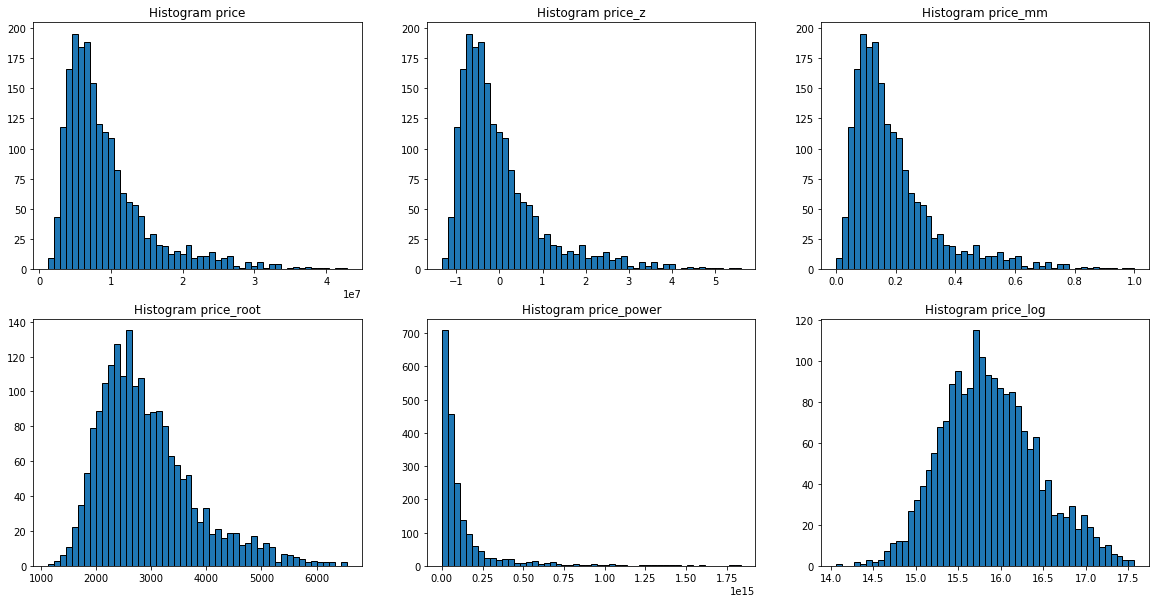

In [287]:
# Plot the result of normalisation/ transformation to see the distribution
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

columns = ['price','price_z','price_mm','price_root','price_power','price_log']
for ax, x in zip(axes.flat, columns):
    ax.hist(df[x], bins=50, edgecolor='black')
    ax.set_title("Histogram "+x)

It can be seen that the original price, price with z-score normalisation, and MinMax normalisation have same distribution pattern which is Log Normal distribution. Price with Root transformation has Binomial distribution. Meanwhile, price with Square Power transformation has Exponential distribution. Finally, price with Log transformation has Normal distribution. Therefore, we can conclude that for price itself, Log transformation is the suitable one because it will give Normal distribution. Normal distribution is important because it makes statistics a lot easier, and more feasible.

## 4.2. Building a Linear Model

In this section, we will find a linear model by using “bedrooms”, “bathrooms”, “parking_space”, and “property_type” as predictors to predict price. First, we will investigate the value of the dataframe.

In [288]:
display(df[['property_type']].describe(include='O'))
df[['bedrooms','bathrooms','parking_space','property_type','price']].describe()

,property_type
count,1965
unique,1
top,house
freq,1965


,bedrooms,bathrooms,parking_space,price
count,1965.000000,1965.000000,1965.000000,1.965000e+03
mean,3.240712,1.568957,1.535369,9.266826e+06
std,0.765586,0.625293,0.788406,6.002745e+06
min,1.000000,1.000000,0.000000,1.280000e+06
25%,3.000000,1.000000,1.000000,5.265000e+06
50%,3.000000,1.000000,2.000000,7.548000e+06
75%,4.000000,2.000000,2.000000,1.116000e+07
max,5.000000,3.000000,3.000000,4.284000e+07


It can be seen that property_type only has 1 single type of value. Therefore, we will ignore it from the predictors. We will use "bedrooms", "bathrooms", and "parking_space" as predictoris to predict price.

### 4.2.1. Data Normalization

In this section, we will apply several data normalization methods and compared them to the original data in order to determine which one gives a better linear model. We will decide a linear model as a good model or not based on the R-squared. 

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean. 100% indicates that the model explains all the variability of the response data around its mean.

We will plot the distribution of original data and find the R-squared value of the linear model.

(<matplotlib.axes._subplots.AxesSubplot at 0x1a1edaf518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1edaf518>)

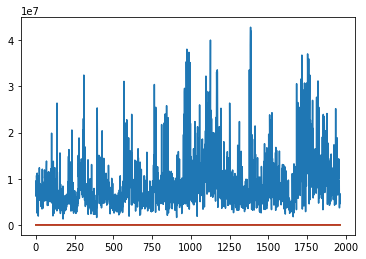

In [289]:
# Plot the original data
df["price"].plot(), df["bedrooms"].plot(), df["bathrooms"].plot(), df["parking_space"].plot()

In [290]:
# regr = linear_model.LinearRegression()
# regr.fit(df[['bedrooms','bathrooms','parking_space']], df['price'] )
# regr.score(df[['bedrooms','bathrooms','parking_space']],df['price'] )

# Build a linear model
X_train, X_test, y_train, y_test = train_test_split(df[['bedrooms','bathrooms','parking_space']], df['price'], random_state=111)
model = LinearRegression()
model.fit(X_train,y_train)
print("The R-squared value is",model.score(X_test,y_test))
print('Coefficients: ', model.coef_)

The R-squared value is 0.0810239622432
Coefficients:  [  236198.43266616  2039286.03433758   323747.19923116]


It can be seen that the price of the original data has a huge distance with the bedrooms, bathrooms and parking_space and the linear model from the original data has R-squared = 0.0810239622432

Next, we will apply Z-Score Normalisation to the original data and see if we can get a better model.

(<matplotlib.axes._subplots.AxesSubplot at 0x1a3b2915f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3b2915f8>)

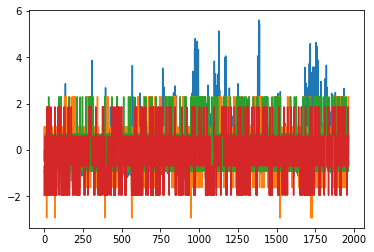

In [291]:
# Apply Z-Score Normalisation
std_scale = preprocessing.StandardScaler().fit(df[['price', 'bedrooms','bathrooms','parking_space']])
df_std = std_scale.transform(df[['price', 'bedrooms','bathrooms','parking_space']])
df_std[0:5]
df['price_z'] = df_std[:,0] 
df['bedrooms_z'] = df_std[:,1]
df['bathrooms_z'] = df_std[:,2]
df['parking_space_z'] = df_std[:,3]

# Plot the result of Z-Score Normalisation
df["price_z"].plot(), df["bedrooms_z"].plot(), df["bathrooms_z"].plot(), df["parking_space_z"].plot()


It can be seen the data is shifted. Now, we will build a new linear model and see if it will give a better linear model or not.

In [292]:
# Build a linear model
X_train, X_test, y_train, y_test = train_test_split(df[['bedrooms_z','bathrooms_z','parking_space_z']], df['price_z'],random_state=111)
model = LinearRegression()
model.fit(X_train,y_train)
print("The R-squared value is",model.score(X_test,y_test))
print('Coefficients: ', model.coef_)

The R-squared value is 0.0810239622432
Coefficients:  [ 0.03012458  0.21242794  0.04252127]


It can be seen that it has a same R-squared with the linear model from the original data. Now, we will try to apply the MinMax Normalisation and investigate the result.

(<matplotlib.axes._subplots.AxesSubplot at 0x1a3b36c668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3b36c668>)

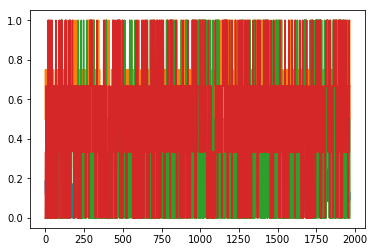

In [293]:
# Apply MinMax Normalisation
minmax_scale = preprocessing.MinMaxScaler().fit(df[['price', 'bedrooms','bathrooms','parking_space']])
df_minmax = minmax_scale.transform(df[['price', 'bedrooms','bathrooms','parking_space']])
df['price_mm'] = df_minmax[:,0] # so 'Ascaled' is Alcohol scaled
df['bedrooms_mm'] = df_minmax[:,1] # and 'MAscaled' is Malic acid scaled
df['bathrooms_mm'] = df_minmax[:,2] # so 'Ascaled' is Alcohol scaled
df['parking_space_mm'] = df_minmax[:,3]

# Plot the result of MinMax Normalisation
df["price_mm"].plot(), df["bedrooms_mm"].plot(), df["bathrooms_mm"].plot(), df["parking_space_mm"].plot()



It can be seen the data is shifted into interval 0 to 1. Now, we will build a new linear model and see if it will give a better linear model or not.

In [294]:
# Build a linear model
X_train, X_test, y_train, y_test = train_test_split(df[['bedrooms_mm','bathrooms_mm','parking_space_mm']], df['price_mm'], random_state=111)
model = LinearRegression()
model.fit(X_train,y_train)
print("The R-squared value is",model.score(X_test,y_test))
print('Coefficients: ', model.coef_)

The R-squared value is 0.0810239622432
Coefficients:  [ 0.02273325  0.09813696  0.02336962]


It can be seen that the R-squared from this model is same with the previous two. From here, we can conclude that normalisation will not affect the linear model. Therefore, we will try data transformation methods and see if we can have a better linear model.

### 4.2.2. Data Transformation

#### 4.2.2.1. Data Transformation on the "Bedrooms"

In this section, we will apply several transformation methods to "Bedrooms" and compared the result to the original data of price and the normalisation/transformation data of price in order to see the relationship of them.

In [295]:
# Apply Root Transformation
df['bed_root'] = np.sqrt(df.bedrooms)

# Apply Square Power Transformation
df['bed_power'] = np.power(df.bedrooms,2)

# Apply Log Transformation
df['bed_log'] = np.log(df.bedrooms)

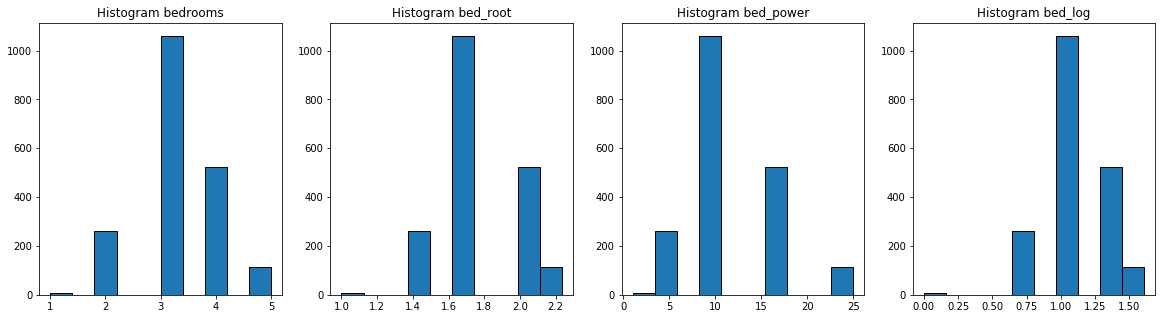

In [296]:
# Plot the distribution of bedrooms and transformed bedrooms
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bedrooms','bed_root','bed_power','bed_log']
for ax, x in zip(axes.flat, columns):
    ax.hist(df[x], edgecolor='black')
    ax.set_title("Histogram "+x)

It can be seen that "bedrooms" is discrete data (1,2,3,4,5). We do not have any other information at this point. Therefore, we will try to plot the relationship between them and price.

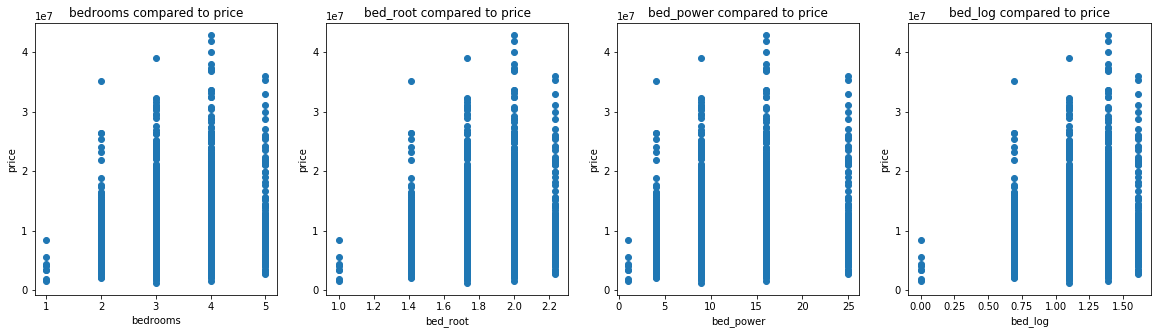

In [297]:
# Plot the relationship between bedrooms and price
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bedrooms','bed_root','bed_power','bed_log']
y = 'price'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

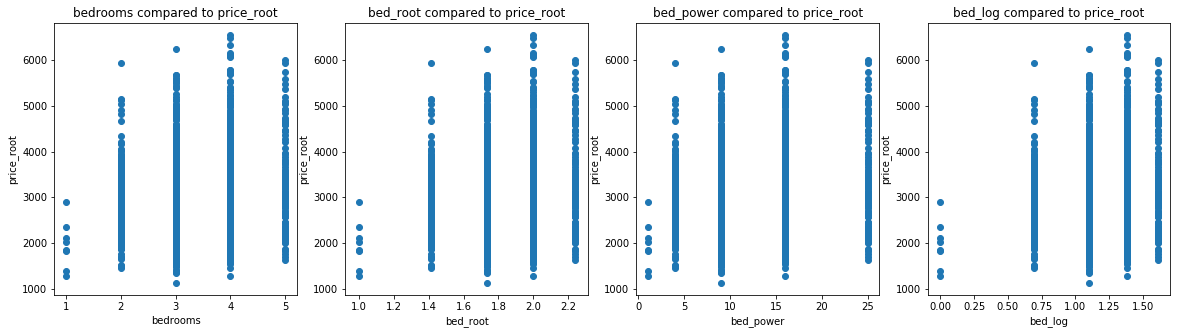

In [298]:
# Plot the relationship between bedrooms and price with Root Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bedrooms','bed_root','bed_power','bed_log']
y = 'price_root'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

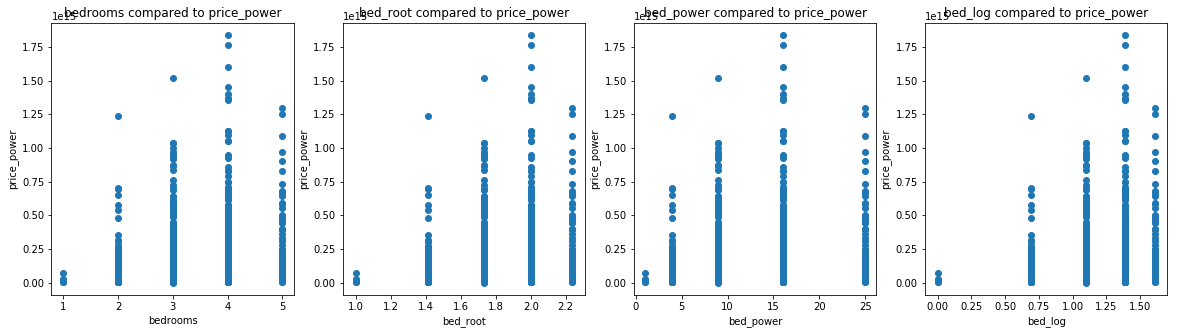

In [299]:
# Plot the relationship between bedrooms and price with Square Power Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bedrooms','bed_root','bed_power','bed_log']
y = 'price_power'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

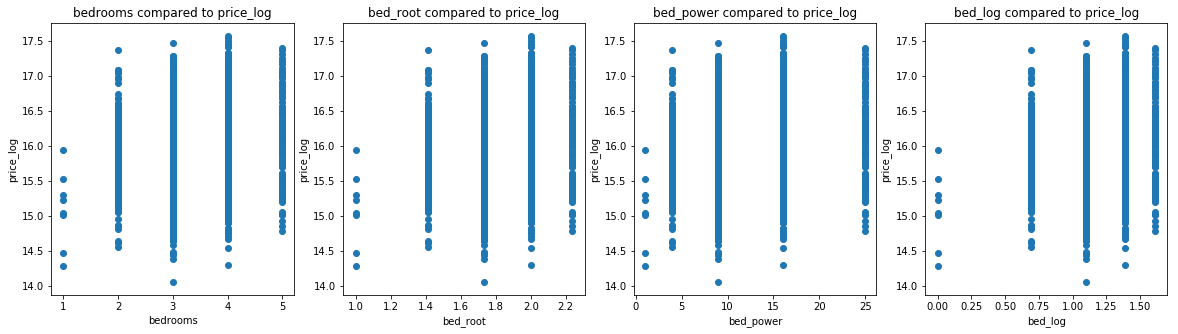

In [300]:
# Plot the relationship between bedrooms and price with Log Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bedrooms','bed_root','bed_power','bed_log']
y = 'price_log'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

From the above scatter plots, it can be seen that bedrooms with Square Power Tranformation compared to price with Square Power Transformation has a good distribution which close to Normal distribution. We will keep in mind this information. We will apply the same transformation methods to the other attributes.

#### 4.2.2.2. Data Transformation on the "Bathrooms"

In this section, we will apply several transformation methods to "Bathrooms" and compared the result to the original data of price and the normalisation/transformation data of price in order to see the relationship of them.

In [301]:
# Apply Root Transformation
df['bath_root'] = np.sqrt(df.bathrooms)

# Apply Square Power Transformation
df['bath_power'] = np.power(df.bathrooms,2)

# Apply Log Transformation
df['bath_log'] = np.log(df.bathrooms)

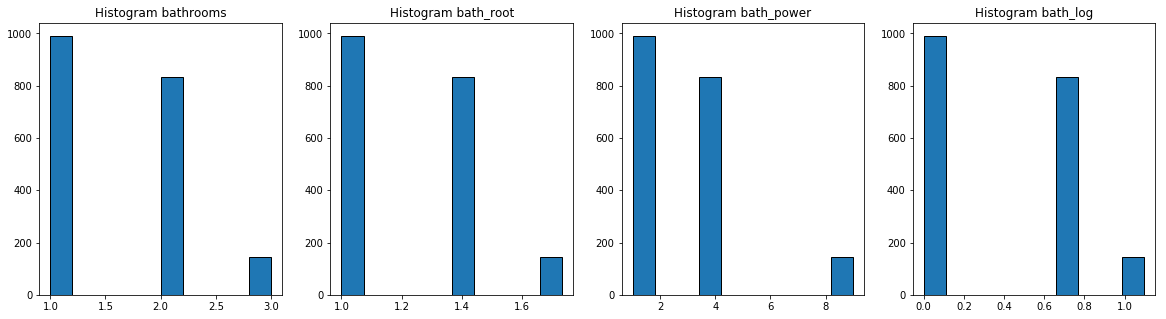

In [302]:
# Plot the distribution of bathrooms and transformed bathrooms
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bathrooms','bath_root','bath_power','bath_log']
for ax, x in zip(axes.flat, columns):
    ax.hist(df[x], edgecolor='black')
    ax.set_title("Histogram "+x)

It can be seen that "bathrooms" is discrete data (1,2,3). We do not have any other information at this point. Therefore, we will try to plot the relationship between them and price.

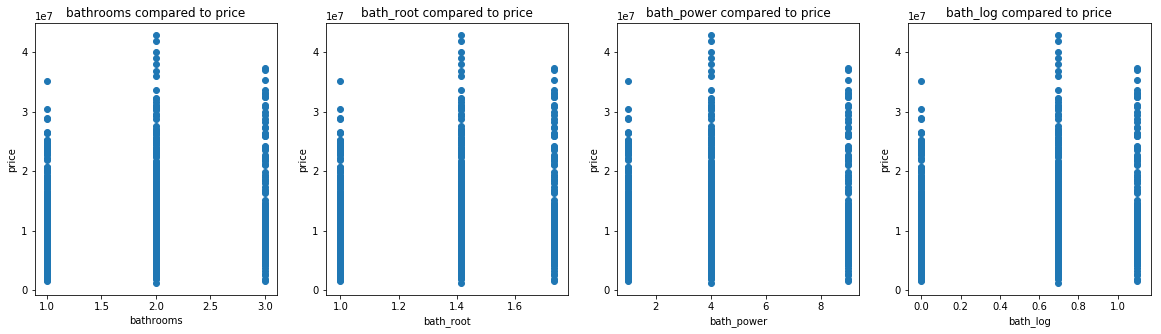

In [303]:
# Plot the relationship between bathrooms and price
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bathrooms','bath_root','bath_power','bath_log']
y = 'price'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

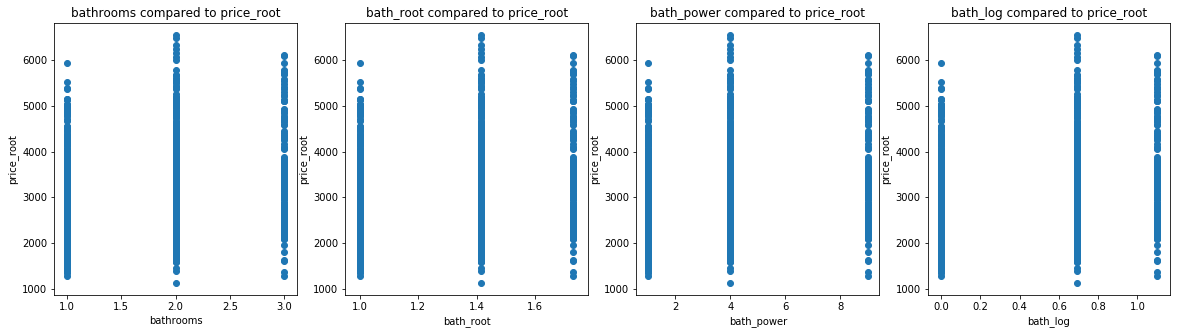

In [304]:
# Plot the relationship between bedrooms and price with Root Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bathrooms','bath_root','bath_power','bath_log']
y = 'price_root'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

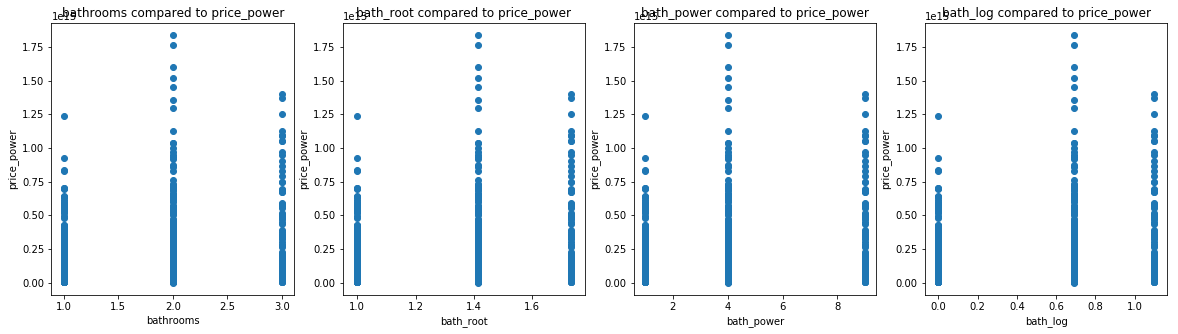

In [305]:
# Plot the relationship between bedrooms and price with Square Power Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bathrooms','bath_root','bath_power','bath_log']
y = 'price_power'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

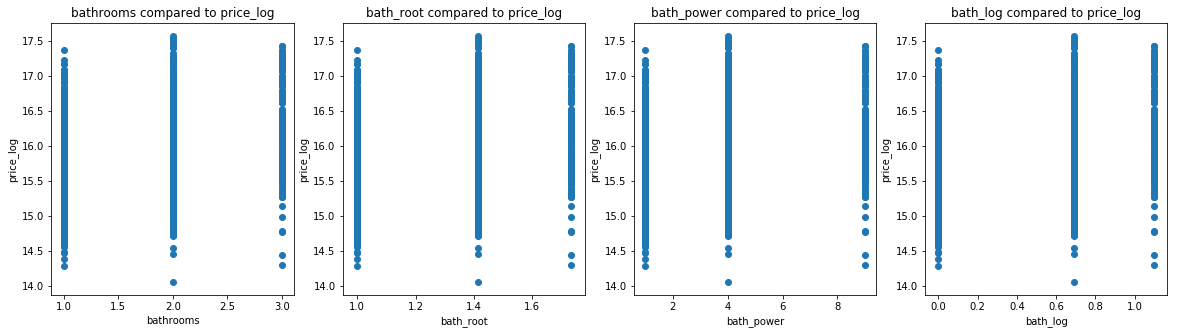

In [306]:
# Plot the relationship between bedrooms and price with Log Transformation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

columns = ['bathrooms','bath_root','bath_power','bath_log']
y = 'price_log'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

From the above scatter plots, it can be seen that bathrooms compared to price with Square Power Transformation has a good distribution which close to Normal distribution. We will keep in mind this information. We will apply the same transformation methods to the other attributes.

#### 4.2.2.3. Data Transformation on the "Parking Space"

In this section, we will apply several transformation methods to "parking_space" and compared the result to the original data of price and the normalisation/transformation data of price in order to see the relationship of them.



In [307]:
# Apply Root Transformation
df['park_root'] = np.sqrt(df['parking_space'])

# Apply Square Power Transformation
df['park_power'] = np.power(df['parking_space'],2)

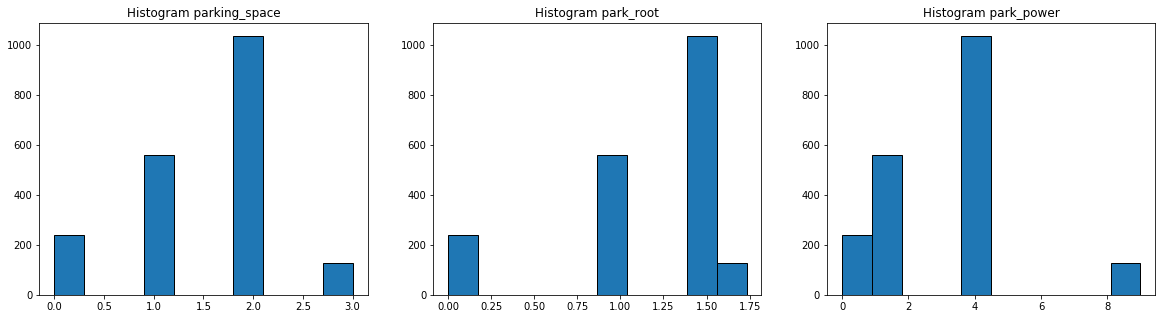

In [308]:
# Plot the distribution of parking_space and transformed parking_space
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

columns = ['parking_space','park_root','park_power']
for ax, x in zip(axes.flat, columns):
    ax.hist(df[x], edgecolor='black')
    ax.set_title("Histogram "+x)

It can be seen that "parking_space" is discrete data (0,1,2,3). We do not have any other information at this point. Therefore, we will try to plot the relationship between them and price.



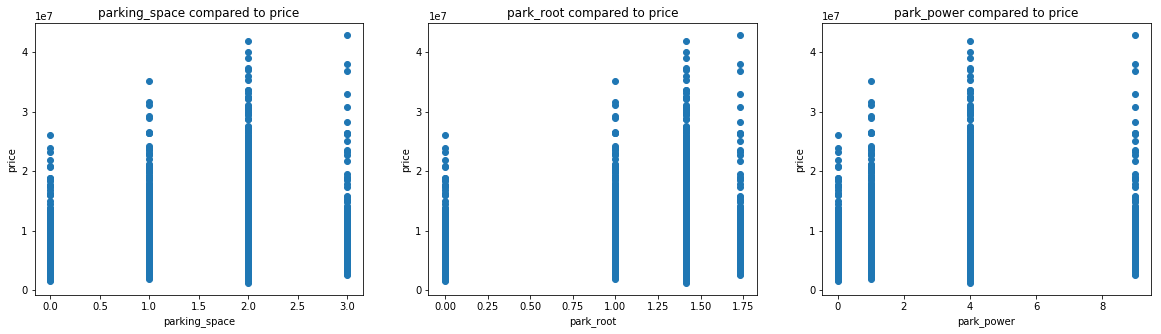

In [309]:
# Plot the relationship between parking_space and price
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

columns = ['parking_space','park_root','park_power']
y = 'price'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

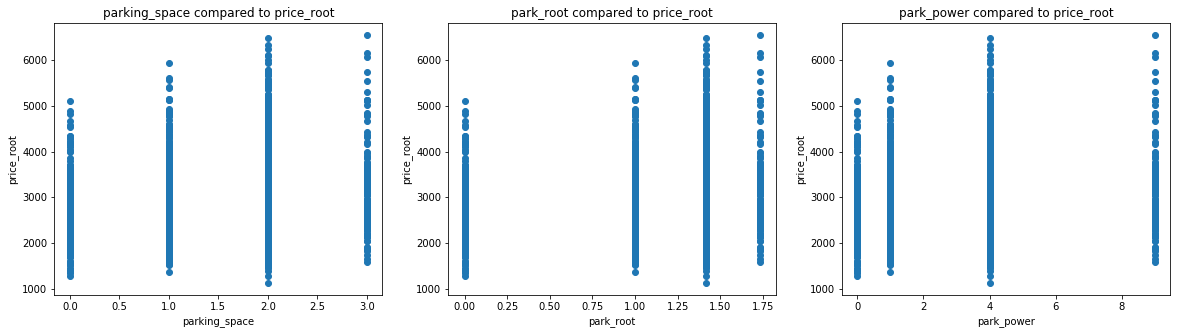

In [310]:
# Plot the relationship between bathrooms and price with Root Transformation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

columns = ['parking_space','park_root','park_power']
y = 'price_root'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

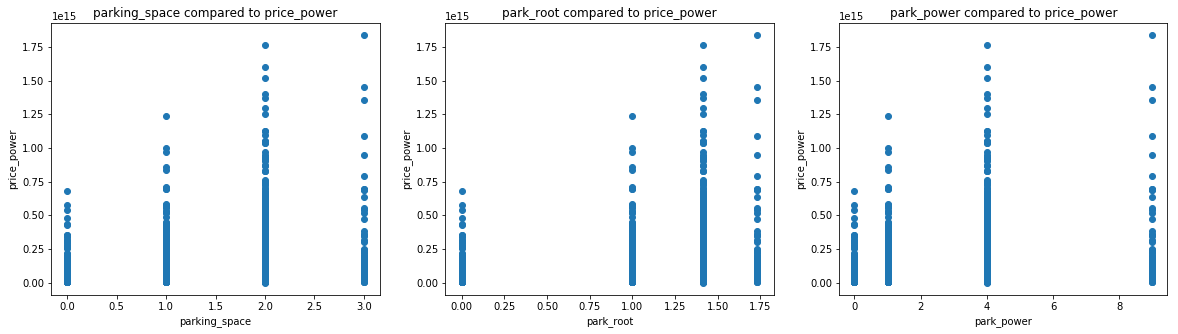

In [311]:
# Plot the relationship between parking_space and price with Squared Power Transformation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

columns = ['parking_space','park_root','park_power']
y = 'price_power'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

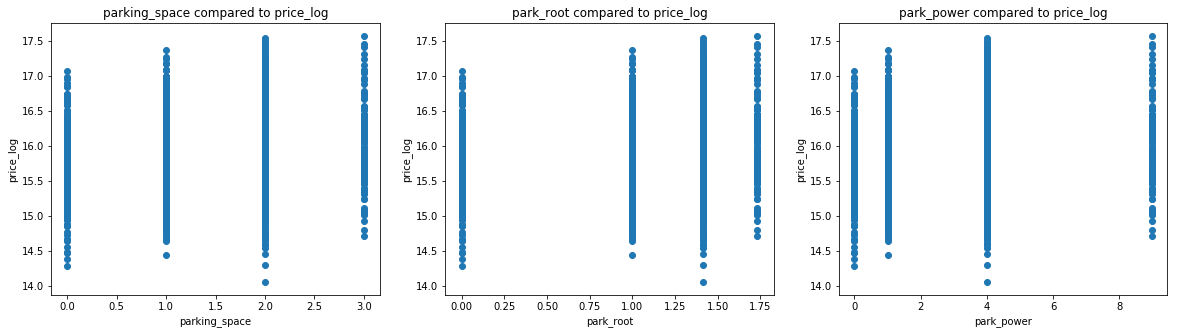

In [312]:
# Plot the relationship between parking_space and price with Log Transformation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

columns = ['parking_space','park_root','park_power']
y = 'price_log'
for ax, x in zip(axes.flat, columns):
    ax.scatter(x,y, data=df)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(x+" compared to "+y)

From above scatter plots, there is no information we can get in order to improve the linear model. Therefore, in the next section we will try to combine all the posibilities in order to get a linear model with highest R-squared.

In [313]:
price_list = ['price','price_z','price_mm', 'price_root', 'price_power', 'price_log']
bed_list = ['bedrooms','bed_root', 'bed_power', 'bed_log']
bath_list = ['bathrooms','bath_root', 'bath_power', 'bath_log']
park_list = ['parking_space','park_root','park_power']

In [314]:
# Finding the model with highest R-squared by using 3 predictors
result = {}
for price in price_list:
    for bed in bed_list:
        for bath in bath_list:
            for park in park_list:
                X_train, X_test, y_train, y_test = train_test_split(df[[bed,bath,park]],df[[price]], random_state=111)
                model = LinearRegression()
                model.fit(X_train,y_train)
                text = price,bed,bath,park
                result[text]=model.score(X_test,y_test)
print("The best linear model is using",", ".join(max(result, key=lambda key: result[key])))
print("The R-squared for this model is",result[max(result, key=lambda key: result[key])])

The best linear model is using price_power, bed_power, bath_power, park_power
The R-squared for this model is 0.106148676898


It can be seen that, the linear model by using bedrooms with Square Power Transformation, bathrooms with Square Power Transformation, parking_space with Square Power Transformation as predictors to predict price with Square Power Transformation gives the highest R-squared. However, how if we reduce the number of predictors. Now, we will try to reduce the number of predictors until 1 and see if the model can give a higher R-squared.

In [315]:
combine_list_2v = bed_list,bath_list,park_list

In [316]:
# Finding the model with highest R-squared by using 2 predictors
result = {}
for price in price_list:
    for i in range(len(combine_list_2v)):
        for j in range(i):
            for each in combine_list_2v[i]:
                for each2 in combine_list_2v[j]:
                    X_train, X_test, y_train, y_test = train_test_split(df[[each,each2]],df[[price]],random_state=111)
                    model = LinearRegression()
                    model.fit(X_train,y_train)
                    text = price,each,each2
                    result[text]=model.score(X_test,y_test)
print("The best linear model is using",", ".join(max(result, key=lambda key: result[key])))
print("The R-squared for this model is",result[max(result, key=lambda key: result[key])])

The best linear model is using price_power, bath_power, bed_power
The R-squared for this model is 0.103954546691


In [317]:
combine_list_1v = bed_list+bath_list+park_list

In [318]:
# Finding the model with highest R-squared by using 1 predictors
result = {}
for price in price_list:
    for each in combine_list_1v:
        X_train, X_test, y_train, y_test = train_test_split(df[[each]],df[[price]],random_state=111)
        model = LinearRegression()
        model.fit(X_train,y_train)
        text = price,each
        result[text]=model.score(X_test,y_test)
print("The best linear model is using",", ".join(max(result, key=lambda key: result[key])))
print("The R-squared for this model is",result[max(result, key=lambda key: result[key])])

The best linear model is using price_power, bath_power
The R-squared for this model is 0.0996419347259


From the above result, it can be seen that:
* With 3 predictors, linear model with bed_power, bath_power, park_power as predictors in order to predict price_power has the highest R-squared which is 0.106148676898
* With 2 predictors, linear model with bed_power, bath_power as predictors in order to predict price_power has the highest R-squared which is 0.103954546691
* With 1 predictor, linear model with bath_power as predictor in order to predict price_power has the highest R-squared which is 0.0996419347259

From here, we can conclude that the best linear model for this assignment is by using bed_power, bath_power, park_power as predictors for price_power. This is inline with the results of the previous explorations.Now we will explore this model.

In [319]:
X_train, X_test, y_train, y_test = train_test_split(df[['bed_power','bath_power','park_power']],df['price_power'], random_state=111)
model = LinearRegression()
model.fit(X_train,y_train)
print('Intercept: ', model.intercept_)
print('Coefficients: ', model.coef_)
print('R-squared: ',model.score(X_test,y_test))

Intercept:  4.39052622155e+13
Coefficients:  [  1.45692344e+12   1.64367129e+13   4.36794939e+12]
R-squared:  0.106148676898


From the result we got R-squared = 0.106148676898

In addtion, we also got coefficients = 1.45692344e+12, 1.64367129e+13, 4.36794939e+12, which means

* bed_power : 1.45692344e+12
* bath_power : 1.64367129e+13
* park_power : 4.36794939e+12

We also got intercept = 4.39052622e+13

Therefore, we can form a linear model

\begin{equation}
y_i = 1.45692344e+12 A_i + 1.64367129e+13 B_i + 4.36794939e+12 C_i + 4.39052622e+13 D_i + E
\end{equation}
 
where: 
* y = price_power (price with Square Power Transformation)
* A = bed_power (bedrooms with Square Power Transformation)
* B = bath_power (bathrooms with Square Power Transformation)
* C = park_power (parking_space with Square Power Transformation)
* E = Intercept

# 5. Conclusion

The given real estate in json and xml formats have 1010 rows and 1004 rows consecutively. However, the output dataset has 1965 rows. This is because we remove 5 rows with NaN value in json file and 11 rows with NaN value in xml file. In addition, we also remove 33 duplicate rows after combining those 2 files.

Meanwhile, for the second task, the R-squared of the linear model is 0.106148676898 which is quite small. Therefore, this is not a good linear model. This happens because all the predictors are discrete variables and we can not predict price by only using those 3 attributes. Price of a property also depends on the location, the public facilities near the property and many other variables.

In conclusion, the linear model still can be improved by adding other attributes as predictors.